# T-Learner and S-Learner Estimators

### Necessary Libraries

In [116]:
! pip install tableone

In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tableone import TableOne
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42 # do not change

In [118]:
data = pd.read_csv("data/sampled_infant_mortality_data_imputed_m1.csv")

In [119]:
confounders = data.columns.tolist()
confounders.remove('T')
confounders.remove('Y')
X = data[confounders]
T = data['T']
y = data['Y']

# Propensity Model

In [120]:
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=RANDOM_SEED)

scale data:

In [121]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled_features = scaler.fit_transform(X_train.values)
X_train= pd.DataFrame(X_train_scaled_features, index=X_train.index, columns=X_train.columns)

X_val_scaled_features = scaler.transform(X_val.values)
X_val = pd.DataFrame(X_val_scaled_features, index=X_val.index, columns=X_val.columns)

In [122]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return 2 * tp / (2 * tp + fp + fn)

In [123]:
def train_propensity_model(model, X_train, T_train):
    """
    Return a fitted propensity model on your training data
    :param model: 
    :param X_train: 
    :param T_train: 
    :return: 
    """
    return model.fit(X_train, T_train)


def weighted_calibration_curve(y_prob, y_true, sample_weights=None, n_bins=10, title=""):
    if sample_weights is None:
        sample_weights = np.ones_like(y_prob)

    # Sort by predicted probabilities
    order = np.argsort(y_prob)
    y_prob = y_prob[order]
    y_true = y_true[order]
    sample_weights = sample_weights[order]

    total_weight = np.sum(sample_weights)
    bin_weight_target = total_weight / n_bins

    bins = []
    cur_w, cur_y_prob, cur_y_true = [], [], []
    w_sum = 0

    for w, p, t in zip(sample_weights, y_prob, y_true):
        cur_w.append(w)
        cur_y_prob.append(p)
        cur_y_true.append(t)
        w_sum += w

        if w_sum >= bin_weight_target and len(bins) < n_bins - 1:
            # Weighted averages
            prob_mean = np.average(cur_y_prob, weights=cur_w)
            true_mean = np.average(cur_y_true, weights=cur_w)
            bins.append((prob_mean, true_mean))
            cur_w, cur_y_prob, cur_y_true = [], [], []
            w_sum = 0

    # last bin
    if cur_w:
        prob_mean = np.average(cur_y_prob, weights=cur_w)
        true_mean = np.average(cur_y_true, weights=cur_w)
        bins.append((prob_mean, true_mean))

    # Plot
    bins = np.array(bins)
    plt.figure(figsize=(8, 6))
    plt.plot(bins[:, 0], bins[:, 1], marker='o', label="Calibration Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly Calibrated')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Mean True Probability")
    plt.title("Weighted Calibration Curve" if title == "" else f"Weighted Calibration Curve - {title}")
    plt.legend()
    plt.grid()
    plt.show()

    return bins

def eval_propensity_model(fitted_model, X_val, T_val, use_sample_weights = False, title = ""):
    """
    Check your fitted propensity model using the brier score and calibration curve.
    
    You must print or return (and then print for us to see) the brier score. 
    You must show the calibration curve.
    :param fitted_model: 
    :param X_val: 
    :param T_val: 
    :return: 
    """
    if use_sample_weights:
        sample_weights = np.where(T_val == 1, 1/np.mean(T_train == 1), 1/np.mean(T_train == 0))
    else:
        sample_weights = np.array([1] * len(T_val))

    sample_weights = pd.Series(sample_weights, name='weights')
    sum_sample_weights = sample_weights.sum()
    print(f"Sum of sample weights: {sum_sample_weights}")

    propensity_scores = fitted_model.predict_proba(X_val)[:, 1]
    propensity_bins = pd.cut(propensity_scores, bins=10, labels=False)

    # ensure everything is 1d
    sample_weights = np.ravel(sample_weights)
    T_val = np.ravel(T_val)
    propensity_scores = np.ravel(propensity_scores)

    brier_score = (sample_weights*((T_val - propensity_scores)**2)).sum() / sum_sample_weights
    suffix = " (weighted)" if use_sample_weights else " (unweighted)"
    print(f"Brier Score{suffix}: {brier_score}")
    print(f"F1 score: {f1_score(T_val, propensity_scores >= 0.5)}")

    if not use_sample_weights:
        # Plotting the calibration curve
        import matplotlib.pyplot as plt
        from sklearn.calibration import calibration_curve
        prob_true, prob_pred = calibration_curve(T_val, propensity_scores, n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve' if title == "" else f'Calibration Curve - {title}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly Calibrated')
        plt.xlabel('Predicted Probability')
        plt.ylabel('True Probability')
        plt.title(f'Calibration Curve')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        weighted_calibration_curve(propensity_scores, T_val, sample_weights=sample_weights, title=title)

    return brier_score


suggested propensity models

In [124]:
# model 1: logostic regression
from sklearn.linear_model import LogisticRegression
def create_logistic_regression(X_train, T_train, class_weights):
    """
    Train a logistic regression model for propensity score estimation.
    :param X_train: 
    :param T_train: 
    :return: 
    """
    model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight=class_weights)
    return model


#model 2: MLP
from torch import nn
import torch
import numpy
def create_neural_network(X_train, T_train):
    """
    Train a neural network model for propensity score estimation.
    :param X_train: 
    :param T_train: 
    :return: 
    """
    class SimpleNN(nn.Module):
        # set seed for reproducibility
        torch.manual_seed(RANDOM_SEED)
        numpy.random.seed(RANDOM_SEED)
        def __init__(self, input_size):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(input_size, 10)
            self.relue = nn.ReLU()
            self.fc2 = nn.Linear(10, 1)
            self.sigmoid = nn.Sigmoid()
            self.last_3_losses = []

        def forward(self, x):
            x = self.fc1(x)
            x = self.relue(x)
            x = self.fc2(x)
            x = self.sigmoid(x)
            return x
        
        def should_stop(self):
            if len(self.last_3_losses) < 4:
                return False
            if self.last_3_losses[-1] > self.last_3_losses[-2] and self.last_3_losses[-2] > self.last_3_losses[-3] and self.last_3_losses[-3] > self.last_3_losses[-4]:
                return True
            return False
        
        def fit(self, X, T):
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
            X_train_tensor = torch.tensor(X.values, dtype=torch.float32)
            T_train_tensor = torch.tensor(T.values, dtype=torch.float32).unsqueeze(1)
            
            best_model = None
            best_loss = float('inf')
            while not self.should_stop():
                self.last_3_losses.append(criterion(self(X_train_tensor), T_train_tensor).item())
                if len(self.last_3_losses) > 4:
                    self.last_3_losses.pop(0)
                optimizer.zero_grad()
                outputs = self(X_train_tensor)
                loss = criterion(outputs, T_train_tensor)
                loss.backward()
                optimizer.step()

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    best_model = self.state_dict()

            self.load_state_dict(best_model)
            self.eval()
            
            return self
        
        def predict_proba(self, X):
            X_tensor = torch.tensor(X.values, dtype=torch.float32)
            with torch.no_grad():
                outputs = self(X_tensor) 

            final_res = numpy.zeros((outputs.shape[0], 2))
            final_res[:, 0] = 1 - outputs.numpy().reshape(-1)
            final_res[:, 1] = outputs.numpy().reshape(-1)   
            return final_res
            
    model = SimpleNN(X_train.shape[1])
    return model 

Sum of sample weights: 37008
Brier Score (unweighted): 0.13713476177631803
F1 score: 0.8839584944573343


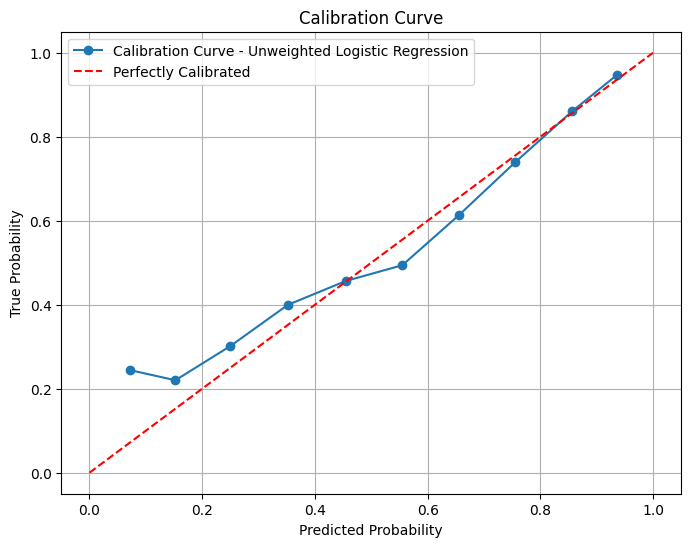

Sum of sample weights: 73949.6593144093
Brier Score (weighted): 0.2411607257701922
F1 score: 0.8839584944573343


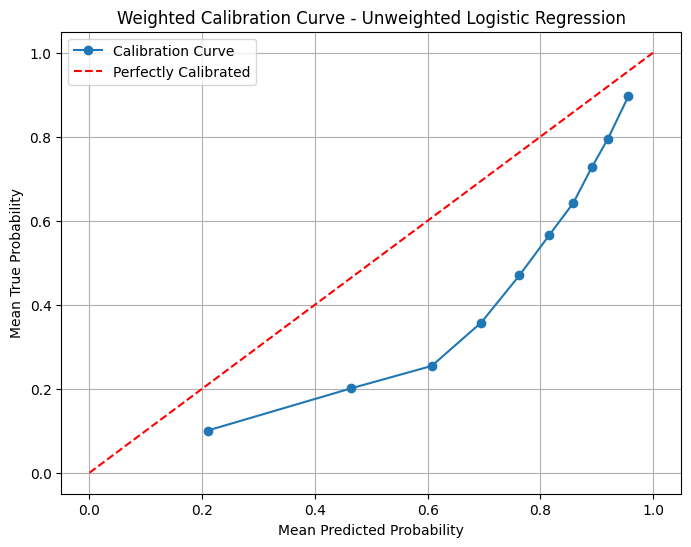

0.2411607257701922

In [125]:
logist_reg_without_class_weights = create_logistic_regression(X_train, T_train, None)

propensity_model_reg = train_propensity_model(logist_reg_without_class_weights, X_train, T_train)
eval_propensity_model(propensity_model_reg, X_val, T_val, title="Unweighted Logistic Regression", use_sample_weights=False)
eval_propensity_model(propensity_model_reg, X_val, T_val, title="Unweighted Logistic Regression", use_sample_weights=True)

Sum of sample weights: 37008
Brier Score (unweighted): 0.18192461151033285
F1 score: 0.8185393895843577


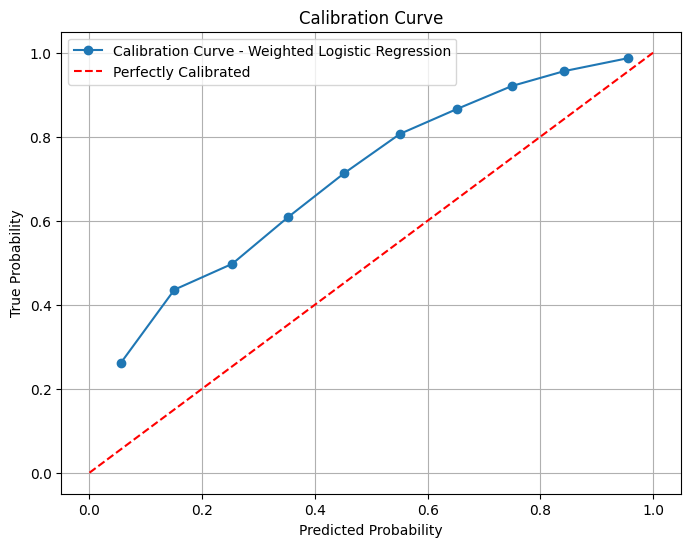

Sum of sample weights: 73949.6593144093
Brier Score (weighted): 0.18473303091042065
F1 score: 0.8185393895843577


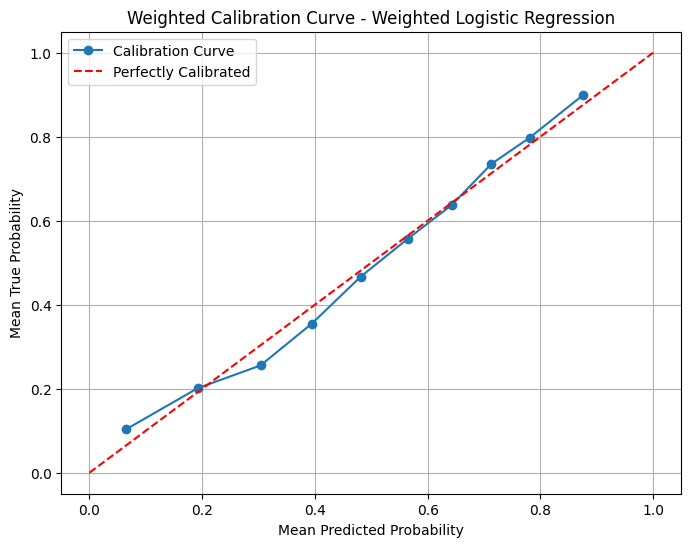

0.18473303091042065

In [126]:
# model 1: Logistic Regression
class_weights = {
    1: 1 / np.mean(T_train == 1),
    0: 1 / np.mean(T_train == 0)
}
logist_reg_with_class_weights = create_logistic_regression(X_train, T_train, class_weights)

propensity_model_reg_with_weights = train_propensity_model(logist_reg_with_class_weights, X_train, T_train)
eval_propensity_model(propensity_model_reg_with_weights, X_val, T_val, title="Weighted Logistic Regression", use_sample_weights=False)
eval_propensity_model(propensity_model_reg_with_weights, X_val, T_val, title="Weighted Logistic Regression", use_sample_weights=True)

Sum of sample weights: 73949.6593144093
Brier Score (weighted): 0.23860411036145698
F1 score: 0.8834995911692559


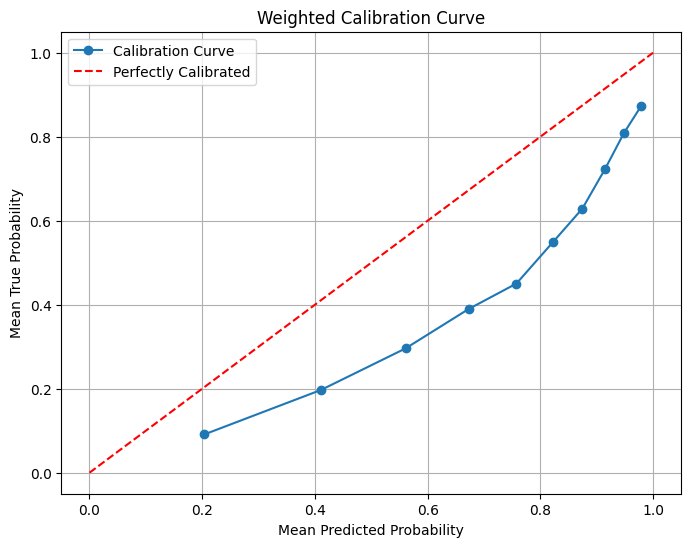

0.23860411036145698

In [127]:
# model 2: Neural Network
nn_model = create_neural_network(X_train, T_train)
propensity_model_nn = train_propensity_model(nn_model, X_train, T_train)
eval_propensity_model(propensity_model_nn, X_val, T_val, use_sample_weights=True)

Sum of sample weights: 73949.6593144093
Brier Score (weighted): 0.23860411036145698
F1 score: 0.8834995911692559


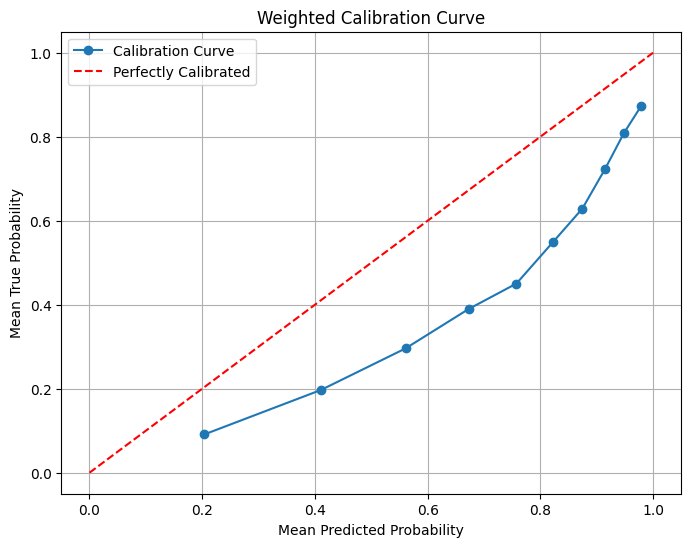

0.23860411036145698

In [128]:
eval_propensity_model(propensity_model_nn, X_val, T_val, use_sample_weights=True)

Sum of sample weights: 73949.6593144093
Brier Score (weighted): 0.18473303091042065
F1 score: 0.8185393895843577


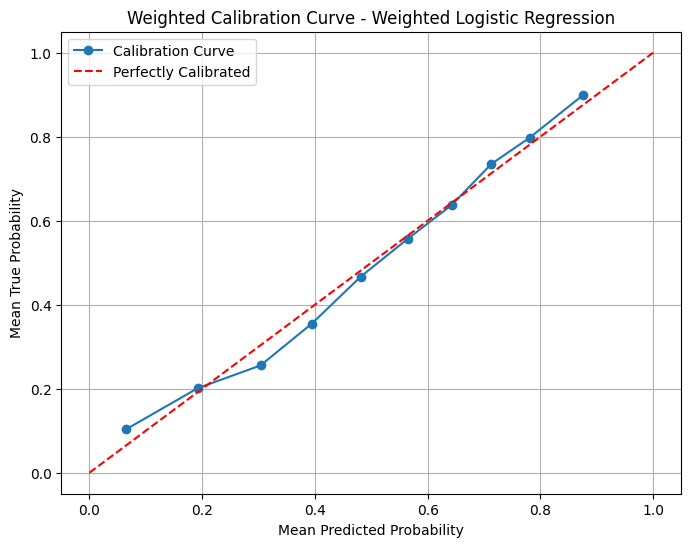

Sum of sample weights: 73949.6593144093
Brier Score (weighted): 0.2411607257701922
F1 score: 0.8839584944573343


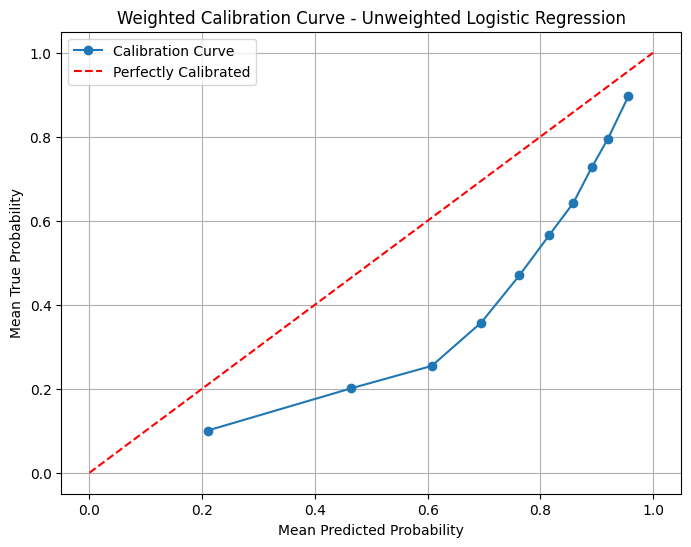

0.2411607257701922

In [129]:
eval_propensity_model(propensity_model_reg_with_weights, X_val, T_val, title="Weighted Logistic Regression", use_sample_weights=True)
eval_propensity_model(propensity_model_reg, X_val, T_val, title="Unweighted Logistic Regression", use_sample_weights=True)

In [130]:
def check_overlap_and_get_trimming_points(propensity_model, X_train, T_train, low_clip=0, high_clip=1, model_name=""):
    """
    Show histograms of the propensity on the T=0 and the T=1 group like in the tutorial
    Use this to ascertain if there is a violation of overlap.
    
    You must show the graph.
    :param propensity_model: 
    :param X_train: 
    :param T_train: 
    :return: 
    """
    
    propensity_scores = propensity_model.predict_proba(X_train)[:, 1]
    max_point = np.percentile(propensity_scores, high_clip)
    min_point = np.percentile(propensity_scores, low_clip)

    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist(propensity_scores[T_train == 0], bins=30, alpha=0.5, label='T=0', color='blue')
    plt.hist(propensity_scores[T_train == 1], bins=30, alpha=0.5, label='T=1', color='orange')
    plt.axvline(max_point, color='red', linestyle='--', label='Max Trimming Point (99th Percentile)')
    plt.axvline(min_point, color='green', linestyle='--', label='Min Trimming Point (1st Percentile)')
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Propensity Score Distribution by Treatment Group' if model_name == "" else f'Propensity Score Distribution by Treatment Group ({model_name})')
    plt.legend()
    plt.grid()
    plt.show()

    return max_point, min_point

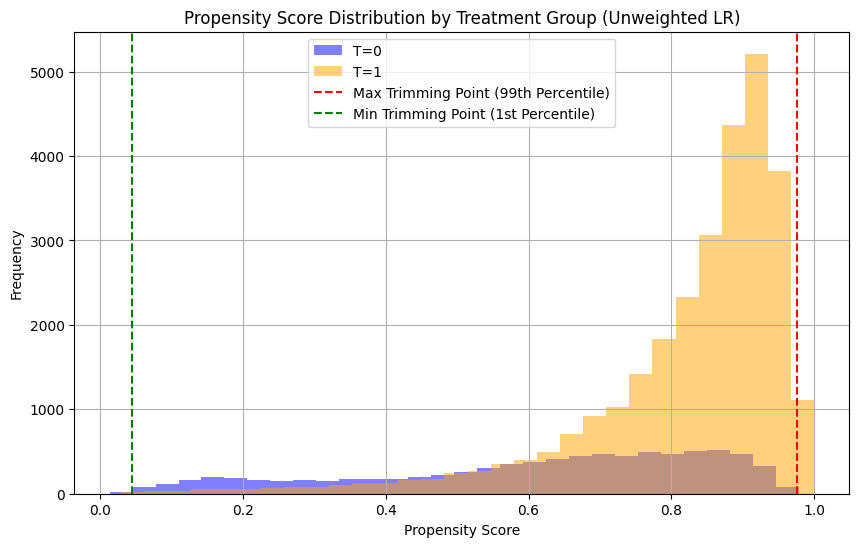

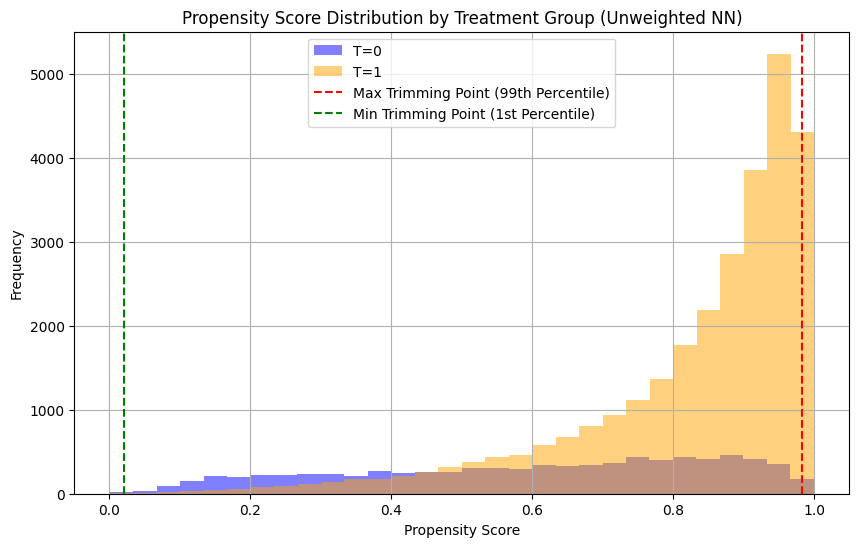

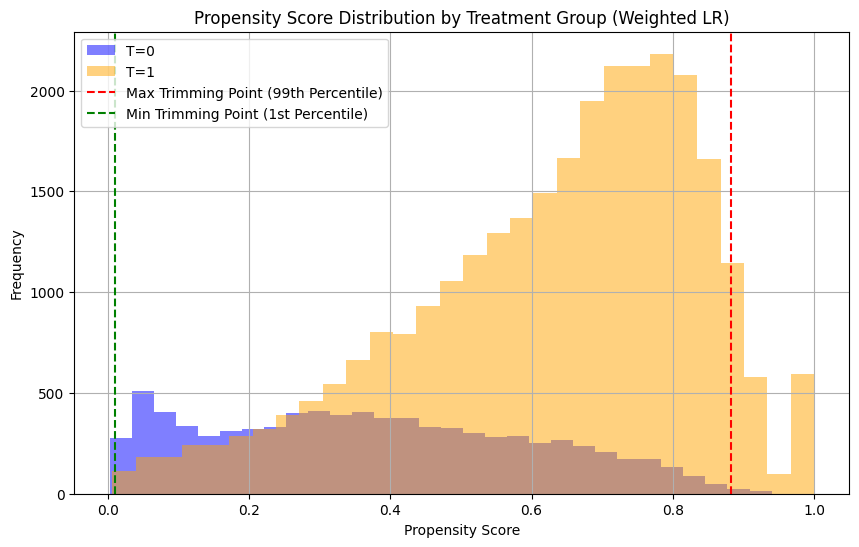

In [131]:
max_point, min_point = check_overlap_and_get_trimming_points(propensity_model_reg, X_val, T_val, 0.05, 98, model_name="Unweighted LR")
max_point_nn, min_point_nn = check_overlap_and_get_trimming_points(propensity_model_nn, X_val, T_val, 0.05, 95, model_name="Unweighted NN")
max_point_weighted, min_point_weighted = check_overlap_and_get_trimming_points(propensity_model_reg_with_weights, X_val, T_val, 0.05, 95, model_name="Weighted LR")

In [132]:
chosen_propensity_model = propensity_model_reg

decide trimming points

In [133]:
T_train_prop = chosen_propensity_model.predict_proba(X_train)[:, 1]

mask_train = (T_train_prop > min_point) & (T_train_prop < max_point)
X_train_trimmed = X_train[mask_train]
T_train_trimmed = T_train[mask_train]
y_train_trimmed = y_train[mask_train]
T_train_prop_trimmed = T_train_prop[mask_train]

print("number of examples removed in train:", X_train.shape[0] - X_train_trimmed.shape[0])
print("number of examples in train after trimming:", X_train_trimmed.shape[0])

T_val_prop = chosen_propensity_model.predict_proba(X_val)[:, 1]
mask_val = (T_val_prop > min_point) & (T_val_prop < max_point)
X_val_trimmed = X_val[mask_val]
T_val_trimmed = T_val[mask_val]
y_val_trimmed = y_val[mask_val]
T_val_prop_trimmed = T_val_prop[mask_val]

print("number of examples removed in val:", X_val.shape[0] - X_val_trimmed.shape[0])
print("number of examples in val after trimming:", X_val_trimmed.shape[0])

number of examples removed in train: 1858
number of examples in train after trimming: 84492
number of examples removed in val: 760
number of examples in val after trimming: 36248


In [134]:
X_train_trimmed['T'] = T_train_trimmed
X_val_trimmed['T'] = T_val_trimmed

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23472\4031557829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_trimmed['T'] = T_train_trimmed
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23472\4031557829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_trimmed['T'] = T_val_trimmed


get label distribution after trimming

In [135]:
X_inference_trimmed_temp = pd.concat([X_train_trimmed, X_val_trimmed], axis = 0)

X_inference_trimmed_temp['y'] = pd.concat([y_train_trimmed, y_val_trimmed], axis = 0)
# get table of T, and y cross counts
T_y_counts = pd.crosstab(X_inference_trimmed_temp['T'], X_inference_trimmed_temp['y'])

display(T_y_counts)

y,0,1
T,,
0.0,16109,11447
1.0,81705,11479


In [136]:

X_val_trimmed_temp = X_val_trimmed.copy()
X_val_trimmed_temp['y'] = y_val_trimmed.copy()
T_y_counts_val = pd.crosstab(X_val_trimmed_temp['T'], X_val_trimmed_temp['y'])

display(T_y_counts_val)

y,0,1
T,,
0.0,4821,3434
1.0,24558,3435


# S-Learner

### Model Selection

suggested models:
- Logistic Regression
- Random Forest
- Neural Network

In [137]:
def train_s_learner(model, X_train, y_train):
    """
    Return a fitted s-learner model on your training data
    :param model: 
    :param X_train: 
    :param y_train: 
    :return: 
    """
    return model.fit(X_train, y_train)

def s_learner_model_selection(models, metric, X_train, y_train, X_val, y_val):
    """
    Use the validation set to select the model with the best performance over the provided metric (e.g. rmse)
    Note that X_train and X_val must include the treatment column for the s-learner.
    
    You may select models in a more complicated way (like you would in real life). But here you can simplify.
    You must either return the fitted model or show the scores that lead to your decision.
    :param model: 
    :param metric:
    :param X_train: 
    :param y_train: 
    :param X_val: 
    :param y_val: 
    :return: 
    """

    models_scores = {model_name: {'score': 0, 'f_model': None} for model_name in models.keys()}

    for model_name, model in models.items():
        # train the model
        fitted_model = train_s_learner(model, X_train, y_train)
        # make predictions on the validation set
        predictions = fitted_model.predict(X_val)
        # calculate the metric
        if metric == 'rmse':
            score = ((predictions - y_val) ** 2).mean() ** 0.5
        elif metric == 'mae':
            score = (abs(predictions - y_val)).mean()
        else:
            raise ValueError("Unsupported metric. Use 'rmse' or 'mae'.")
        
        models_scores[model_name]['score'] = score
        models_scores[model_name]['f_model'] = fitted_model

        print(f"Model: {model_name}, {metric.upper()}: {score}")

    # Select the model with the best score
    best_model_name = min(models_scores, key=lambda k: models_scores[k]['score'])
    print(f"Best model: {best_model_name} with {metric.upper()}: {models_scores[best_model_name]['score']}")

    return models_scores[best_model_name]['f_model']

In [138]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return 2 * tp / (2 * tp + fp + fn)


### Logistic Regression

In [139]:
class AbstractModel:
    def __init__(self, **params):
        raise NotImplementedError

    def fit(self, X, y, sample_weights=None):
        raise NotImplementedError

    def predict(self, X):
        raise NotImplementedError

    def evaluate_model(self, X, y):
        raise NotImplementedError

    def get_model_no_train(self):
        raise NotImplementedError

In [140]:
from sklearn.linear_model import LogisticRegression

class LogisticRegressionModel(AbstractModel):
    def __init__(self, params):
        self.params = params
        self.model = LogisticRegression(**params)

    def fit(self, X_train, y_train, sample_weights=None):
        self.model.fit(X_train, y_train, sample_weight=sample_weights)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        return {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
        }

    def get_model_no_train(self):
        return LogisticRegressionModel(self.params)

In [141]:
parameters_dict_logist_reg = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2', 'elasticnet', None]
}

IPW weighing:<br>

using propensity scores to reweight the samples so the models process the data as randomly assigned treatment data.

Min class weight: 1.0251901740271439
Max class weight: 22.16845866966173
Mean class weight: 1.548998591848783
Median class weight: 1.1900450839642565


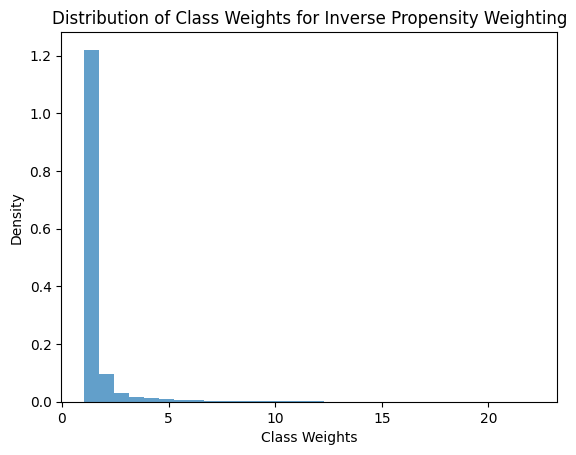

In [142]:
sample_weights = T_train_prop_trimmed**-1

print("Min class weight:", sample_weights.min())
print("Max class weight:", sample_weights.max())
print("Mean class weight:", sample_weights.mean())
print("Median class weight:", np.median(sample_weights))

# plot distribution

plt.hist(sample_weights, bins=30, alpha=0.7, density=True)
plt.xlabel('Class Weights')
plt.ylabel('Density')
plt.title('Distribution of Class Weights for Inverse Propensity Weighting')
plt.show()

class weighing:

In [143]:
class_weights_rand_forest = class_weights_logist_reg = {
    1: 1 / np.mean(X_train_trimmed['T'] == 1),
    0: 1 / np.mean(X_train_trimmed['T'] == 0)
}

In [144]:
results_dict_logist_reg = {(c, p): 0 for c in parameters_dict_logist_reg['C'] for p in parameters_dict_logist_reg['penalty']}

In [145]:
best_model_logist_reg = None
best_f1_score_logist_reg = 0

for c in parameters_dict_logist_reg['C']:
    for p in parameters_dict_logist_reg['penalty']:
        key = (c, p)
        
        # Set up parameters for the model
        model_params = {
            'C': c, 
            'penalty': p, 
            'max_iter': 100, 
            'class_weight': class_weights_logist_reg,
            'solver': 'saga' if p in ['l1', 'elasticnet'] else 'lbfgs',
            'random_state': RANDOM_SEED
        }
        
        # Add l1_ratio for elasticnet penalty
        if p == 'elasticnet':
            model_params['l1_ratio'] = 0.5  # Equal mix of L1 and L2
            
        logist_reg_model = LogisticRegressionModel(model_params)

        # print(len(X_train_trimmed), len(y_train_trimmed), len(sample_weights))
        logist_reg_model.fit(X_train_trimmed, y_train_trimmed, sample_weights=sample_weights)
        results_dict_logist_reg = logist_reg_model.evaluate_model(X_val_trimmed, y_val_trimmed)
        print(f"Model with C={c}, penalty={p} - Accuracy: {results_dict_logist_reg['accuracy']}, F1 Score: {results_dict_logist_reg['f1_score']}")

        # Check if this model is the best one so far
        if results_dict_logist_reg['f1_score'] > best_f1_score_logist_reg:
            best_f1_score_logist_reg = results_dict_logist_reg['f1_score']
            best_model_logist_reg = logist_reg_model
            best_f1_score = results_dict_logist_reg['f1_score']
            best_model = logist_reg_model

84492 84492 84492


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model with C=0.1, penalty=l1 - Accuracy: 0.9124365482233503, F1 Score: 0.7083792723263506
84492 84492 84492
Model with C=0.1, penalty=l2 - Accuracy: 0.912574486868241, F1 Score: 0.7088654111162149
84492 84492 84492


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Model with C=0.1, penalty=elasticnet - Accuracy: 0.9124917236813066, F1 Score: 0.7086165717435238
84492 84492 84492
Model with C=0.1, penalty=None - Accuracy: 0.9126572500551755, F1 Score: 0.7092211609110948
84492 84492 84492


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model with C=1.0, penalty=l1 - Accuracy: 0.9125468991392629, F1 Score: 0.7087467842704888
84492 84492 84492
Model with C=1.0, penalty=l2 - Accuracy: 0.9126572500551755, F1 Score: 0.7092211609110948
84492 84492 84492


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model with C=1.0, penalty=elasticnet - Accuracy: 0.9125468991392629, F1 Score: 0.7087467842704888
84492 84492 84492
Model with C=1.0, penalty=None - Accuracy: 0.9126572500551755, F1 Score: 0.7092211609110948
84492 84492 84492


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model with C=10.0, penalty=l1 - Accuracy: 0.912574486868241, F1 Score: 0.7088654111162149
84492 84492 84492
Model with C=10.0, penalty=l2 - Accuracy: 0.9126572500551755, F1 Score: 0.7092211609110948
84492 84492 84492


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Model with C=10.0, penalty=elasticnet - Accuracy: 0.9126020745972192, F1 Score: 0.7089840161675547
84492 84492 84492
Model with C=10.0, penalty=None - Accuracy: 0.9126572500551755, F1 Score: 0.7092211609110948


Getting ATE:

In [146]:
def prepare_data_for_s_learner_inference(X):
    """
    Receives X, data, and returns two sets of data. One with T=1 and the other with T=0.
    For example, if the X = [x1, x_2] then this function returns X1 = [x1, x2, 1] and X0 = [x1, x2, 0]
    
    You must return two datasets, one for T=1 and one for T=0.
    :param X: 
    :return: 
    """
    X1 = X.copy()
    X0 = X.copy()
    X1['T'] = 1
    X0['T'] = 0
    return X1, X0

def calculate_s_learner_ate(s_learner_model, X):
    """
    Receives an s learner model and data
    
    You must return or print the ate estimation on X based on the S-Learner.
    :param s_learner: 
    :param X: 
    :return: 
    """
    
    X1, X0 = prepare_data_for_s_learner_inference(X)
    ate = s_learner_model.predict(X1).mean() - s_learner_model.predict(X0).mean()
    return ate

In [147]:
X_inference_trimmed = pd.concat([X_train_trimmed, X_val_trimmed], axis = 0)
y_inference_trimmed = pd.concat([y_train_trimmed, y_val_trimmed], axis = 0)

display(X_inference_trimmed.head(3))
print(X_inference_trimmed.shape)

,FAGECOMB,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,RF_PPB,RF_INFT,RF_DRG,RF_ART,...,DPLURAL_4,DPLURAL_5,SETORDER_R_,SETORDER_R_1,SETORDER_R_2,SETORDER_R_3,SETORDER_R_4,SETORDER_R_5,SETORDER_R_9,T
5234,-0.000037,-0.10257,-0.233153,-0.140518,-0.243385,-0.057545,-0.194032,-0.138794,-0.092972,0.084903,...,-0.017018,-0.006806,-0.130273,-0.164051,6.046471,-0.028888,-0.009004,-0.004813,-3.632212,0.0
115412,0.265910,-0.10257,-0.233153,-0.140518,-0.243385,-0.057545,-0.194032,-0.138794,-0.092972,0.084903,...,-0.017018,-0.006806,-0.130273,-0.164051,-0.165386,-0.028888,-0.009004,-0.004813,0.275314,1.0
111103,-0.364505,-0.10257,-0.233153,-0.140518,-0.243385,-0.057545,-0.194032,-0.138794,-0.092972,0.084903,...,-0.017018,-0.006806,-0.130273,-0.164051,-0.165386,-0.028888,-0.009004,-0.004813,0.275314,0.0


(120740, 242)


In [148]:
print(f"Estimated ATE: {calculate_s_learner_ate(best_model_logist_reg, X_inference_trimmed)}")

Estimated ATE: -0.008439622328971344


### Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestModel(AbstractModel):
    def __init__(self, params):
        self.params = params
        self.model = RandomForestClassifier(**params)

    def fit(self, X, y, sample_weights=None):
        self.model.fit(X, y, sample_weight=sample_weights)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate_model(self, X, y):
        preds = self.model.predict(X)
        return {
            'accuracy_score' : accuracy_score(y, preds),
            'f1_score' : f1_score(y, preds)
        }

    def get_model_no_train(self):
        return RandomForestModel(self.params)

In [150]:
parameters_dict_rand_forest = {
    'n_estimators': [50, 100],
    'max_depth': [None, 12, 13, 14],
    'min_weight_fraction_leaf': [0.0, 0.05, 0.1],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

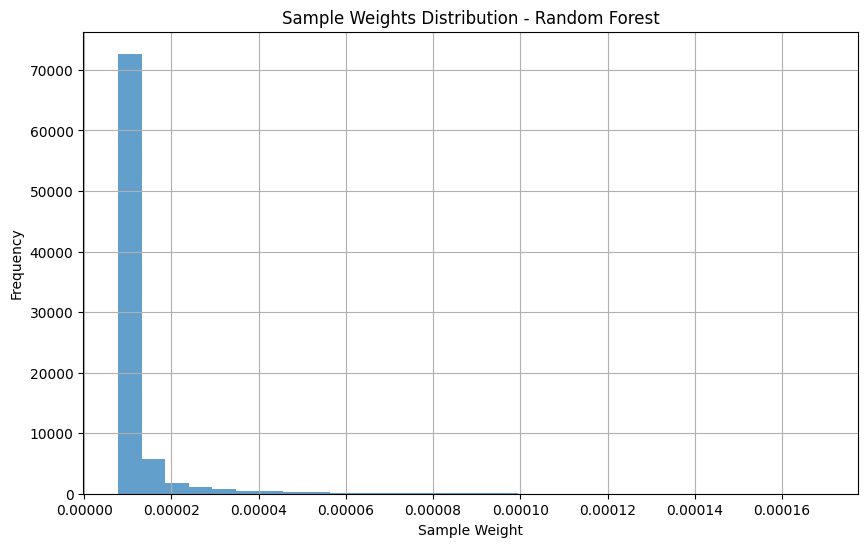

In [151]:
sample_weights_rand_forest = (T_train_prop_trimmed**-1)/(T_train_prop_trimmed**-1).sum()

# plot sample weights distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(sample_weights_rand_forest, bins=30, alpha=0.7)
plt.title('Sample Weights Distribution - Random Forest')
plt.xlabel('Sample Weight')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [152]:
results_dict_rand_forest = {(ne, md, mwfl, cr): 0 for ne in parameters_dict_rand_forest['n_estimators'] for md in parameters_dict_rand_forest['max_depth'] for mwfl in parameters_dict_rand_forest['min_weight_fraction_leaf'] for cr in parameters_dict_rand_forest['criterion']}

In [153]:
best_model_rand_forest = None
best_f1_score_rand_forest = 0

for ne in parameters_dict_rand_forest['n_estimators']:
    for md in parameters_dict_rand_forest['max_depth']:
        for mwfl in parameters_dict_rand_forest['min_weight_fraction_leaf']:
            for cr in parameters_dict_rand_forest['criterion']:
                key = (ne, md, mwfl, cr)

                model_params_rand_forest = {
                    'n_estimators': ne,
                    'max_depth': md,
                    'min_weight_fraction_leaf': mwfl,
                    'criterion': cr,
                    'class_weight': class_weights_rand_forest,
                    'random_state': RANDOM_SEED
                }
                rand_forest_model = RandomForestModel(model_params_rand_forest)
                rand_forest_model.fit(X_train_trimmed, y_train_trimmed, sample_weights=sample_weights_rand_forest)

                results_dict_rand_forest = rand_forest_model.evaluate_model(X_val_trimmed, y_val_trimmed)

                print(f"Model with n_estimators={ne}, max_depth={md}, min_weight_fraction_leaf={mwfl}, criterion={cr} - Accuracy: {results_dict_rand_forest['accuracy_score']}, F1 Score: {results_dict_rand_forest['f1_score']}")

                if results_dict_rand_forest['f1_score'] > best_f1_score_rand_forest:
                    best_f1_score_rand_forest = results_dict_rand_forest['f1_score']
                    best_model_rand_forest = rand_forest_model

Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.0, criterion=gini - Accuracy: 0.9193886559258442, F1 Score: 0.7520787374851519
Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.0, criterion=entropy - Accuracy: 0.9192507172809534, F1 Score: 0.7492933618843683
Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.0, criterion=log_loss - Accuracy: 0.9192507172809534, F1 Score: 0.7492933618843683
Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.05, criterion=gini - Accuracy: 0.877400132421099, F1 Score: 0.5259227650949435
Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.05, criterion=entropy - Accuracy: 0.8775380710659898, F1 Score: 0.5267086043288197
Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.05, criterion=log_loss - Accuracy: 0.8775380710659898, F1 Score: 0.5267086043288197
Model with n_estimators=50, max_depth=None, min_weight_fraction_leaf=0.1, criterion=

Getting ATE:

In [154]:
print(f"Estimated ATE: {calculate_s_learner_ate(best_model_rand_forest, X_inference_trimmed)}")

Estimated ATE: 0.0062365413284744264


### Neural Network

In [155]:
import torch
from torch import nn

class NeuralNetworkModel(nn.Module, AbstractModel):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(NeuralNetworkModel, self).__init__()
        # set random seed for reproducibility
        torch.manual_seed(RANDOM_SEED)
        numpy.random.seed(RANDOM_SEED)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def fit(self, X, y, epochs=100, batch_size=32, sample_weights=None):
        X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.BCEWithLogitsLoss(reduction='none')

        for epoch in range(epochs):
            for i in range(0, X.size(0), batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                if sample_weights is not None:
                    sample_weights_batch = sample_weights[i:i + batch_size]
                else:
                    sample_weights_batch = None

                optimizer.zero_grad()
                logits = self(X_batch).reshape(-1)
                loss = criterion(logits, y_batch)
                if sample_weights_batch is not None:
                    loss = loss * sample_weights_batch
                loss = loss.mean()
                loss.backward()
                optimizer.step()

    def predict(self, X):
        self.eval()
        X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        with torch.no_grad():
            logits = self(X)
            probs = torch.sigmoid(logits)
            return np.array((probs > 0.5).float().reshape(-1), dtype=int)

    def evaluate_model(self, X, y):
        y = y.to_numpy() 
        preds = self.predict(X)
        return {
            'accuracy_score' : accuracy_score(y, preds),
            'f1_score' : f1_score(y, preds)
        }
    
    def get_model_no_train(self, input_dim = None, output_dim = None):

        if input_dim is None:
            input_dim = self.input_dim
        if output_dim is None:
            output_dim = self.output_dim

        return NeuralNetworkModel(input_dim, output_dim, self.hidden_dim)


In [156]:
sample_weights_nn = (T_train_prop_trimmed**-1)/(T_train_prop_trimmed**-1).sum()
sample_weights_nn = torch.tensor(sample_weights_nn, dtype=torch.float32)

In [157]:
parameters_dict_nn = {
    'hidden_dim': [128]#, 64, 32]
}

In [158]:
results_dict_nn = {hd: 0 for hd in parameters_dict_nn['hidden_dim']}

In [159]:
best_model_nn = None
best_f1_score_nn = 0

for hd in parameters_dict_nn['hidden_dim']:
    model = NeuralNetworkModel(input_dim=X_train_trimmed.shape[1], output_dim=1, hidden_dim=hd)
    model.fit(X_train_trimmed, y_train_trimmed)
    results = model.evaluate_model(X_val_trimmed, y_val_trimmed)
    results_dict_nn[hd] = results

    print(f"Results for hidden_dim={hd}: {results}")

    if results['f1_score'] > best_f1_score_nn:
        best_f1_score_nn = results['f1_score']
        best_model_nn = model

Results for hidden_dim=128: {'accuracy_score': 0.9135124696534981, 'f1_score': 0.7396395648201977}


Get ATE:

In [160]:
print(f"Estimated ATE (Neural Network) {calculate_s_learner_ate(best_model_nn, X_inference_trimmed)}")

Estimated ATE (Neural Network) -0.006335928441278782


Getting Confidence Intervals

In [161]:
def s_learner_confidence_intervals(s_learner_model, X_train, y_train, X_val, y_val):
    """
    Receives an s-learner model and returns 95% confidence intervals.
    You do not need to use every parameter passed to this method and you can add additional parameters.
    
    You must either print, visualize the confidence intervals or return them as a list.
    :param s_learner_model: 
    :param X_train: 
    :param y_train: 
    :param X_val: 
    :param y_val: 
    :return: 
    """
    
    # calculating bootstrap confidence intervals for the ATE estimate

    import numpy as np

    
    bootstrap_samples_num = 20
    alpha = 0.05

    s_learner_model_train_data = X_train.copy()

    bootstrap_sample_size = int(0.1 * s_learner_model_train_data.shape[0])
    s_learner_model_test_treatment1, s_learner_model_test_treatment0 = prepare_data_for_s_learner_inference(X_val)

    np.random.seed(RANDOM_SEED)
    ate_estimates = []
    # Bootstrap sampling and model fitting
    for i in range(bootstrap_samples_num):
        # Generate bootstrap indices
        bootstrap_indices = np.random.choice(s_learner_model_train_data.index,
                                            size=bootstrap_sample_size,
                                            replace=True)
        # Create the bootstrap sample using the indices
        X_train_resampled = s_learner_model_train_data.loc[bootstrap_indices]
        y_train_resampled = y_train.loc[bootstrap_indices]
        s_learner_model.fit(X_train_resampled, y_train_resampled)
        # Predict the two potential outcomes and calculate ATE
        y1_pred = s_learner_model.predict(s_learner_model_test_treatment1)
        y0_pred = s_learner_model.predict(s_learner_model_test_treatment0)
        ate_estimate = np.mean(y1_pred - y0_pred)
        ate_estimates.append(ate_estimate)

    # Convert the list of estimates into a numpy array
    s_bootstrap_estimates = np.array(ate_estimates)

    # Calculate the lower and upper percentiles to get the CI
    s_ci = np.percentile(s_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

    # Print the confidence interval (for example, for the first prediction)
    print(f"95% Confidence Interval: Lower = {s_ci[0]}, Upper = {s_ci[1]}")

    return s_ci, s_bootstrap_estimates

In [162]:
dummy_logist_reg_model = best_model_logist_reg.get_model_no_train()
dummy_rand_forest_model = best_model_rand_forest.get_model_no_train()
dummy_nn_model = best_model_nn.get_model_no_train()

bootstrap_reses_s_learner = {
    "logist_reg": s_learner_confidence_intervals(dummy_logist_reg_model, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed),
    "rand_forest": s_learner_confidence_intervals(dummy_rand_forest_model, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed),
    "nn": s_learner_confidence_intervals(dummy_nn_model, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed),
}

c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting pena

95% Confidence Interval: Lower = -0.012346888104171266, Upper = -0.004401622158463917
95% Confidence Interval: Lower = -0.008698410946810859, Upper = -0.0032298333701169728
95% Confidence Interval: Lower = -0.027120116971970868, Upper = -0.013599370999779299


plot boxplot of each bootstrap estimates:

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23472\2822716881.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


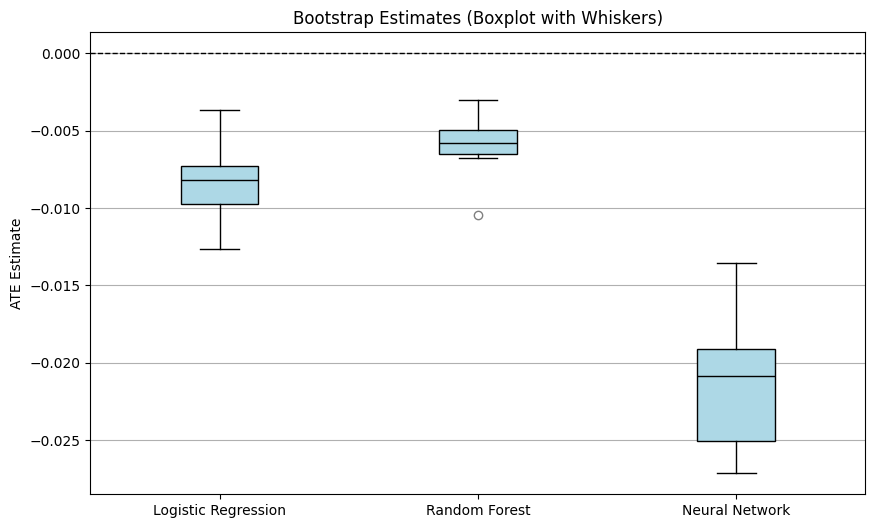

In [181]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_bootstrap_estimates(bootstrap_estimates_list, titles, dot_color = "red", ci=95):
    plt.figure(figsize=(10, 6))

    for i, res in enumerate(bootstrap_estimates_list, start=1):
        mean_est = np.mean(res)
        lower = np.percentile(res, (100 - ci) / 2)
        upper = np.percentile(res, 100 - (100 - ci) / 2)

        if mean_est - lower > 0 and upper - mean_est > 0:
            # Error bar with caps
            plt.errorbar(
                i, mean_est,
                yerr=[[mean_est - lower], [upper - mean_est]],
                fmt="o", color= dot_color, ecolor="black", capsize=5, markersize=6
            )
        else:
            # Error bar without caps
            plt.errorbar(
                i, mean_est,
                # yerr=[[mean_est - lower], [upper - mean_est]],
                fmt="o", color= dot_color, ecolor="black", capsize=0, markersize=6
            )

        # Add label with mean value
        plt.text(i + 0.1, mean_est, f"{mean_est:.2f}", va="center", fontsize=9)

    plt.title("Bootstrap Estimates with Confidence Intervals")
    plt.ylabel("ATE Estimate")
    # plt.xlabel("Models", fontsize=8)
    plt.xticks(range(1, len(bootstrap_estimates_list) + 1), 
               titles)
    plt.grid(True, axis="y")
    plt.show()

def plot_bootstrap_estimates_boxplot(bootstrap_estimates_list, titles, box_color="lightblue", show_mean=True):
    plt.figure(figsize=(10, 6))

    # Add horizontal black line at 0
    plt.axhline(0, color="black", linestyle="--", linewidth=1)

    # Classic boxplot with whiskers
    box = plt.boxplot(
        bootstrap_estimates_list,
        labels=titles,
        patch_artist=True,
        notch=False,
        showfliers=True,  # set False if you want to hide outliers
        boxprops=dict(facecolor=box_color, color="black"),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(marker="o", color="gray", alpha=0.5)
    )

    # # Optionally add mean values as red dots with labels
    # if show_mean:
    #     for i, res in enumerate(bootstrap_estimates_list, start=1):
    #         mean_est = np.mean(res)
    #         plt.plot(i, mean_est, "o", color=dot_color)
    #         plt.text(i + 0.1, mean_est, f"{mean_est:.2f}", va="center", fontsize=9, color=dot_color)

    plt.title("Bootstrap Estimates (Boxplot with Whiskers)")
    plt.ylabel("ATE Estimate")
    plt.grid(True, axis="y")
    plt.show()

plot_bootstrap_estimates_boxplot([v[1] for v in bootstrap_reses_s_learner.values()], ['Logistic Regression', 'Random Forest', 'Neural Network'], box_color="lightblue")

In [165]:
# save bootstrap reses to json file
import json

def save_bootstrap_reses_to_json(bootstrap_reses, filename):
    bootstrap_reses_to_json = dict()

    for key in bootstrap_reses.keys():
        bootstrap_reses_to_json[key] = (list(bootstrap_reses[key][0]), list(bootstrap_reses[key][1]))

    with open(f"reses/direct estimation reses/{filename}", "w") as f:
        json.dump(bootstrap_reses_to_json, f)

save_bootstrap_reses_to_json(bootstrap_reses_s_learner, "bootstrap_reses_s_learner.json")

# T-learners

using best learners acquired by previous steps

In [166]:
# initializing models for T=1
logist_reg_model_1 = best_model_logist_reg.get_model_no_train()
rand_forest_model_1 = best_model_rand_forest.get_model_no_train()
nn_model_1 = NeuralNetworkModel(input_dim=X_train_trimmed.shape[1]-1, output_dim=1, hidden_dim=128) #best_model_nn.get_model_no_train()

# initializing models for T=0
logist_reg_model_0 = best_model_logist_reg.get_model_no_train()
rand_forest_model_0 = best_model_rand_forest.get_model_no_train()
nn_model_0 = NeuralNetworkModel(input_dim=X_train_trimmed.shape[1]-1, output_dim=1, hidden_dim=128) #best_model_nn.get_model_no_train()

In [167]:
def calculate_t_learner_ate(t_learner_model1, t_learner_model0, X):
    """
    Receive t-learners and data, return the ATE inferred over X
    
    You must return or print the ate estimation on X based on the T-Learner.
    :param t_learner_model: 
    :param X1: 
    :param X0: 
    :return: 
    """

    if 'T' in X.columns:
        X = X.drop(columns=['T'])
    ate = t_learner_model1.predict(X).mean() - t_learner_model0.predict(X).mean()
    return ate

data preparation

In [168]:
# for T=1
X_inference_trimmed_1 = X_inference_trimmed[X_inference_trimmed['T'] == 1].drop(columns=['T'])
y_inference_trimmed_1 = y_inference_trimmed[X_inference_trimmed['T'] == 1]

# for T=0
X_inference_trimmed_0 = X_inference_trimmed[X_inference_trimmed['T'] == 0].drop(columns=['T'])
y_inference_trimmed_0 = y_inference_trimmed[X_inference_trimmed['T'] == 0]


In [169]:
def train_and_evaluate_T_learner(model_1, model_0, X_train, y_train, X_val, y_val, model_name = ""):
    model_1 = model_1.get_model_no_train()
    model_0 = model_0.get_model_no_train()
    
    X_train_1 = X_train[X_train['T'] == 1].drop(columns=['T'])
    X_train_0 = X_train[X_train['T'] == 0].drop(columns=['T'])
    y_train_1 = y_train[X_train['T'] == 1]
    y_train_0 = y_train[X_train['T'] == 0]

    X_val_0 = X_val[X_val['T'] == 0].drop(columns=['T'])
    X_val_1 = X_val[X_val['T'] == 1].drop(columns=['T'])
    y_val_0 = y_val[X_val['T'] == 0]
    y_val_1 = y_val[X_val['T'] == 1]

    model_1.fit(X_train_1, y_train_1)
    model_0.fit(X_train_0, y_train_0)

    print(f"Model 1 ({model_name}) VAL score: {model_1.evaluate_model(X_val_1, y_val_1)}")
    print(f"Model 0 ({model_name}) VAL score: {model_0.evaluate_model(X_val_0, y_val_0)}")

    print(f"Model 1 ({model_name}) TRAIN score: {model_1.evaluate_model(X_train_1, y_train_1)}")
    print(f"Model 0 ({model_name}) TRAIN score: {model_0.evaluate_model(X_train_0, y_train_0)}")

    print(f"Estimated ATE (T-Learner) {model_name}: {calculate_t_learner_ate(model_1, model_0, X_val)}")

### logistic regression

In [170]:
train_and_evaluate_T_learner(logist_reg_model_1, logist_reg_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, "Logistic Regression")

c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Model 1 (Logistic Regression) VAL score: {'accuracy': 0.925338477476512, 'f1_score': 0.5801526717557252}
Model 0 (Logistic Regression) VAL score: {'accuracy': 0.8763173834039976, 'f1_score': 0.8299183741462602}
Model 1 (Logistic Regression) TRAIN score: {'accuracy': 0.9258179810096485, 'f1_score': 0.5870901639344263}
Model 0 (Logistic Regression) TRAIN score: {'accuracy': 0.8804725143774934, 'f1_score': 0.8358357646054223}
Estimated ATE (T-Learner) Logistic Regression: -0.010372986095784603


### Random Forest

In [171]:
train_and_evaluate_T_learner(rand_forest_model_1, rand_forest_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, "Random Forest")

Model 1 (Random Forest) VAL score: {'accuracy_score': 0.9303754510056086, 'f1_score': 0.6434973477226998}
Model 0 (Random Forest) VAL score: {'accuracy_score': 0.8867353119321624, 'f1_score': 0.8531490497879692}
Model 1 (Random Forest) TRAIN score: {'accuracy_score': 1.0, 'f1_score': 1.0}
Model 0 (Random Forest) TRAIN score: {'accuracy_score': 0.9999481892129941, 'f1_score': 0.9999375975039002}
Estimated ATE (T-Learner) Random Forest: -0.01746303244316927


### Neural Network

In [172]:
train_and_evaluate_T_learner(nn_model_1, nn_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, "Neural Network")

Model 1 (Neural Network) VAL score: {'accuracy_score': 0.9227306826706677, 'f1_score': 0.6271332528874332}
Model 0 (Neural Network) VAL score: {'accuracy_score': 0.8719563900666263, 'f1_score': 0.8363523765288744}
Model 1 (Neural Network) TRAIN score: {'accuracy_score': 0.9767605957877621, 'f1_score': 0.8970298375586216}
Model 0 (Neural Network) TRAIN score: {'accuracy_score': 0.9981348116677893, 'f1_score': 0.9977488744372186}
Estimated ATE (T-Learner) Neural Network: -0.012331714853233283


### Bootstrap CE

In [173]:
def bootstrap_confidence_interval_t_learner(model_1, model_0, X_train, y_train, X_val, y_val, alpha=0.05, bootstrap_sample_size=10000):
    ate_estimates = []
    bootstrap_samples_num = 20
    # Bootstrap sampling and model fitting
    for i in range(bootstrap_samples_num):
        # Generate bootstrap indices
        bootstrap_indices = np.random.choice(X_train.index,
                                            size = bootstrap_sample_size,
                                            replace=True)
        # Create the bootstrap sample using the indices
        X_train_resampled = X_train.loc[bootstrap_indices]
        y_train_resampled = y_train.loc[bootstrap_indices]
        
        # train separate model on treatment=1 data
        X_train1_resampled = X_train_resampled[X_train_resampled['T'] == 1]
        y_train1_resampled = y_train_resampled[X_train_resampled['T'] == 1]
        X_train1_resampled = X_train1_resampled.drop(columns=['T'])
        model_1.fit(X_train1_resampled, y_train1_resampled)
        # train separate model on treatment=0 data
        X_train0_resampled = X_train_resampled[X_train_resampled['T'] == 0]
        y_train0_resampled = y_train_resampled[X_train_resampled['T'] == 0]
        X_train0_resampled = X_train0_resampled.drop(columns=['T'])
        model_0.fit(X_train0_resampled, y_train0_resampled)
        
        X_test = X_val.drop(columns=['T'])
        # Predict the two potential outcomes and calculate ATE
        y1_pred = model_1.predict(X_test)
        y0_pred = model_0.predict(X_test)
        ate_estimate = np.mean(y1_pred - y0_pred)
        ate_estimates.append(ate_estimate)

    # Convert the list of estimates into a numpy array
    t_bootstrap_estimates = np.array(ate_estimates)

    # Calculate the lower and upper percentiles to get the CI
    t_ci = np.percentile(t_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

    # Print the confidence interval (for example, for the first prediction)
    print(f"95% Confidence Interval: Lower = {t_ci[0]}, Upper = {t_ci[1]}")

    return t_ci, t_bootstrap_estimates

In [174]:
bootstrap_reses_t_learner = {
    "logist_reg": bootstrap_confidence_interval_t_learner(logist_reg_model_1, logist_reg_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed),
    "rand_forest": bootstrap_confidence_interval_t_learner(rand_forest_model_1, rand_forest_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed),
    "nn": bootstrap_confidence_interval_t_learner(nn_model_1, nn_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed),
}

c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting pena

95% Confidence Interval: Lower = -0.029140918119620392, Upper = -0.013179347826086958
95% Confidence Interval: Lower = -0.026682851467667183, Upper = -0.013975253807106602
95% Confidence Interval: Lower = -0.043663098653718826, Upper = -0.010011586846170826


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23472\2822716881.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


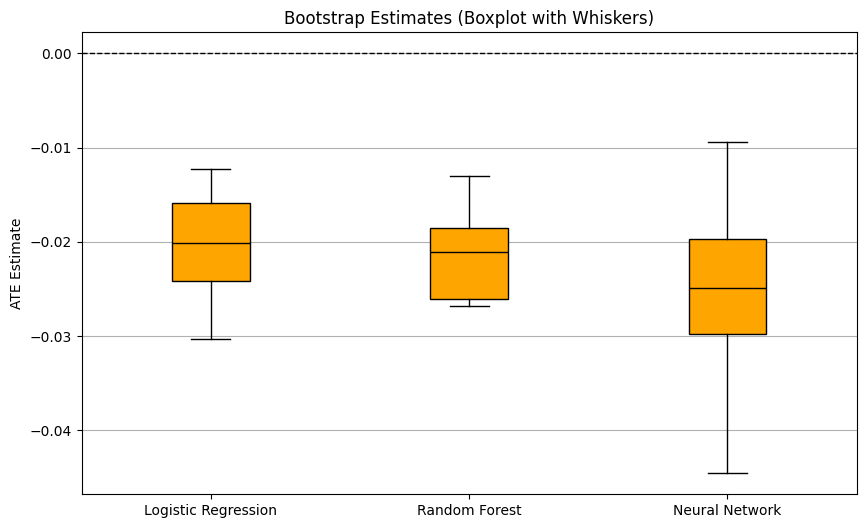

In [ ]:
plot_bootstrap_estimates_boxplot([v[1] for v in bootstrap_reses_t_learner.values()], ['Logistic Regression', 'Random Forest', 'Neural Network'], box_color="orange")

In [ ]:
save_bootstrap_reses_to_json(bootstrap_reses_t_learner, "bootstrap_reses_t_learner.json")

# IPW

In [ ]:
from copy import deepcopy


def bootstrap_confidence_interval_ipw(X_train, y_train, X_val, y_val, propensity_model):
    bootstrap_sample_size = X_train.shape[0] #int(0.1 * X_train.shape[0])
    bootstrap_sample_num = 100
    alpha = 0.05
    np.random.seed(42)
    ate_estimates = []
    # Bootstrap sampling and model fitting
    for i in range(bootstrap_sample_num):
        # Generate bootstrap indices
        bootstrap_indices = np.random.choice(X_train.index,
                                            size=bootstrap_sample_size,
                                            replace=True)
        # Create the bootstrap sample using the indices
        X_train_resampled = X_train.loc[bootstrap_indices]
        # T_train_resampled = T_train.loc[bootstrap_indices]
        cur_class_weights = {
            0: 1 / np.mean(X_train_resampled['T'] == 0),
            1: 1 / np.mean(X_train_resampled['T'] == 1)
        }
        old_params = propensity_model.get_params()
        IPW_model = LogisticRegression(**old_params) # best previously found propensity model
        IPW_model.fit(X_train_resampled.drop(columns='T', inplace = False), X_train_resampled['T'])

        # get propensity on test
        temp_test_data = deepcopy(X_val)
        temp_test_data['propensity'] = IPW_model.predict_proba(temp_test_data.drop(columns='T', inplace = False))[:,1]

        # print(f1_score(temp_test_data['T'], (temp_test_data['propensity'] > 0.5).astype(int)))
        # print(min(temp_test_data['propensity']), max(temp_test_data['propensity']))
        y1_weighted_estimate = np.sum(((temp_test_data['T'] == 1).astype(int) * y_val) / temp_test_data['propensity']) / np.sum(temp_test_data['T'] == 1)
        y0_weighted_estimate = np.sum(((temp_test_data['T'] == 0).astype(int) * y_val) / (1 - temp_test_data['propensity'])) / np.sum(temp_test_data['T'] == 0)
        ate_estimate = y1_weighted_estimate - y0_weighted_estimate
        ate_estimates.append(ate_estimate)

    # Convert the list of estimates into a numpy array
    ipw_bootstrap_estimates = np.array(ate_estimates)

    # Calculate the lower and upper percentiles to get the CI
    ipw_ci = np.percentile(ipw_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

    # Print the confidence interval (for example, for the first prediction)
    print(f"95% Confidence Interval: Lower = {ipw_ci[0]}, Upper = {ipw_ci[1]}")

    return ipw_ci, ipw_bootstrap_estimates

In [186]:
bootstrap_reses_ipw = {"logist_reg_ipw": bootstrap_confidence_interval_ipw(X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model)}

KeyboardInterrupt: 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23472\2724101187.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


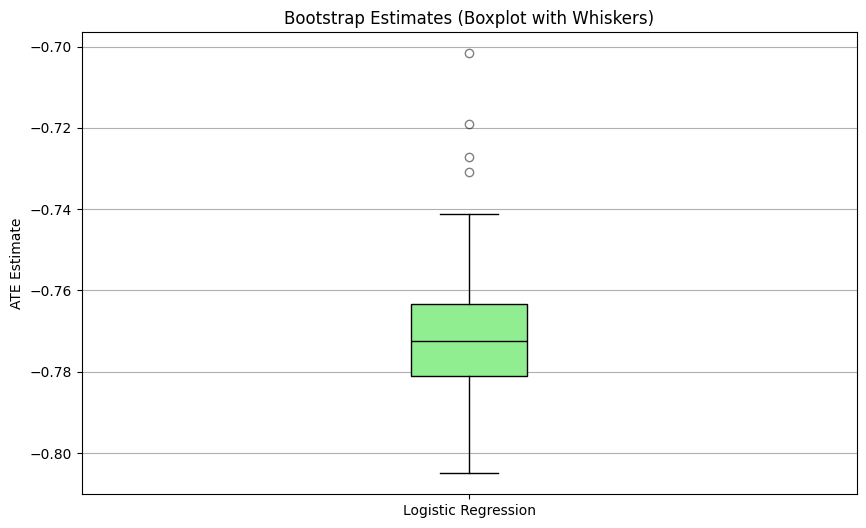

In [ ]:
plot_bootstrap_estimates_boxplot([v[1] for v in bootstrap_reses_ipw.values()], ['Logistic Regression'], box_color="lightgreen")

In [ ]:
temp_test_data = deepcopy(X_val_trimmed)
temp_test_data['propensity'] = chosen_propensity_model.predict_proba(temp_test_data.drop(columns='T', inplace = False))[:,1]

y1_weighted_estimate = np.sum(((temp_test_data['T'] == 1).astype(int) * y_val_trimmed) / temp_test_data['propensity']) / np.sum(temp_test_data['T'] == 1)
y0_weighted_estimate = np.sum(((temp_test_data['T'] == 0).astype(int) * y_val_trimmed) / (1 - temp_test_data['propensity'])) / np.sum(temp_test_data['T'] == 0)

print(f"Estimated ATE (IPW): {y1_weighted_estimate - y0_weighted_estimate}")

Estimated ATE (IPW): 0.11693254746276627


In [ ]:
save_bootstrap_reses_to_json(bootstrap_reses_ipw, "bootstrap_reses_ipw.json")

# DR-Learner

### T-Learner

In [ ]:
def dr_estimator(row, potential_outcome):
    estimated_outcome = row['y1_estimate'] if potential_outcome == 1 else row['y0_estimate']
    if row['T'] == potential_outcome:
        estimated_propensity = row['propensity'] if potential_outcome == 1 else 1 - row['propensity']
        weighted_error = (row['Y'] - estimated_outcome)/ estimated_propensity
        return estimated_outcome + weighted_error
    else:
        return estimated_outcome



def bootstrap_confidence_interval_dr_t_learner(t_learner_outcome_model1, t_learner_outcome_model0, X_train, y_train, X_val, y_val, propensity_model, sample_size=10000, sample_num=20):
    np.random.seed(42)
    bootstrap_sample_size = sample_size
    bootstrap_sample_num = sample_num
    alpha = 0.05
    test_data  = pd.concat([X_val, y_val], axis=1)
    t_learner_model_train_data = deepcopy(X_train) # notice that T is not included in learning
    ate_estimates = []
    # Bootstrap sampling and model fitting
    for i in range(bootstrap_sample_num):
        t_learner_outcome_model1 = t_learner_outcome_model1.get_model_no_train()
        t_learner_outcome_model0 = t_learner_outcome_model0.get_model_no_train()
        old_params = propensity_model.get_params()
        IPW_model = LogisticRegression(**old_params) # best previously found propensity model
        # Generate bootstrap indices
        bootstrap_indices = np.random.choice(t_learner_model_train_data.index,
                                            size=bootstrap_sample_size,
                                            replace=True)
        # Create the bootstrap sample using the indices
        X_train_resampled = t_learner_model_train_data.loc[bootstrap_indices]
        y_train_resampled = y_train.loc[bootstrap_indices]

        # train separate model on treatment=1 data
        X_train1_resampled = X_train_resampled[X_train_resampled['T'] == 1].drop(columns=['T'], inplace=False)
        y_train1_resampled = y_train_resampled[X_train_resampled['T'] == 1]
        t_learner_outcome_model1.fit(X_train1_resampled, y_train1_resampled)
        # train separate model on treatment=0 data
        X_train0_resampled = X_train_resampled[X_train_resampled['T'] == 0].drop(columns=['T'], inplace=False)
        y_train0_resampled = y_train_resampled[X_train_resampled['T'] == 0]
        t_learner_outcome_model0.fit(X_train0_resampled, y_train0_resampled)

        # fit propensity model
        IPW_model.fit(X_train_resampled.drop(columns=['T']), X_train_resampled['T'])
        # get propensity on test
        temp_test_data = deepcopy(test_data)
        temp_test_data['propensity'] = IPW_model.predict_proba(temp_test_data[confounders])[:, 1]
        temp_test_data['y1_estimate'] = t_learner_outcome_model1.predict(X_val.drop(columns=['T'], inplace=False))
        temp_test_data['y0_estimate'] = t_learner_outcome_model0.predict(X_val.drop(columns=['T'], inplace=False))
        temp_test_data['dr1_estimate'] = temp_test_data.apply(lambda x: dr_estimator(x, 1), axis=1)
        temp_test_data['dr0_estimate'] = temp_test_data.apply(lambda x: dr_estimator(x, 0), axis=1)
        ate_estimate = np.mean(temp_test_data['dr1_estimate'] - temp_test_data['dr0_estimate'])
        ate_estimates.append(ate_estimate)

    # Convert the list of estimates into a numpy array
    dr_bootstrap_estimates = np.array(ate_estimates)

    # Calculate the lower and upper percentiles to get the CI
    dr_ci = np.percentile(dr_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

    # Print the confidence interval (for example, for the first prediction)
    print(f"95% Confidence Interval: Lower = {dr_ci[0]}, Upper = {dr_ci[1]}")

    return dr_ci, ate_estimates

In [ ]:
results_dict_dr_t_learner = {
    "logist_reg": bootstrap_confidence_interval_dr_t_learner(logist_reg_model_1, logist_reg_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model, sample_size=X_train_trimmed.shape[0], sample_num=20),
    "rand_forest": bootstrap_confidence_interval_dr_t_learner(rand_forest_model_1, rand_forest_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model, sample_size=X_train_trimmed.shape[0], sample_num=20),
    "nn": bootstrap_confidence_interval_dr_t_learner(nn_model_1, nn_model_0, X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model, sample_size=10000, sample_num=20),
}

c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lenovo\miniconda3\Lib\site-packages\skl

95% Confidence Interval: Lower = 0.07675891447844456, Upper = 0.10954374047514054


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please

95% Confidence Interval: Lower = 0.024181399255445563, Upper = 0.04195657845720933


c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please

95% Confidence Interval: Lower = 0.039084311872213166, Upper = 0.039084311872213166


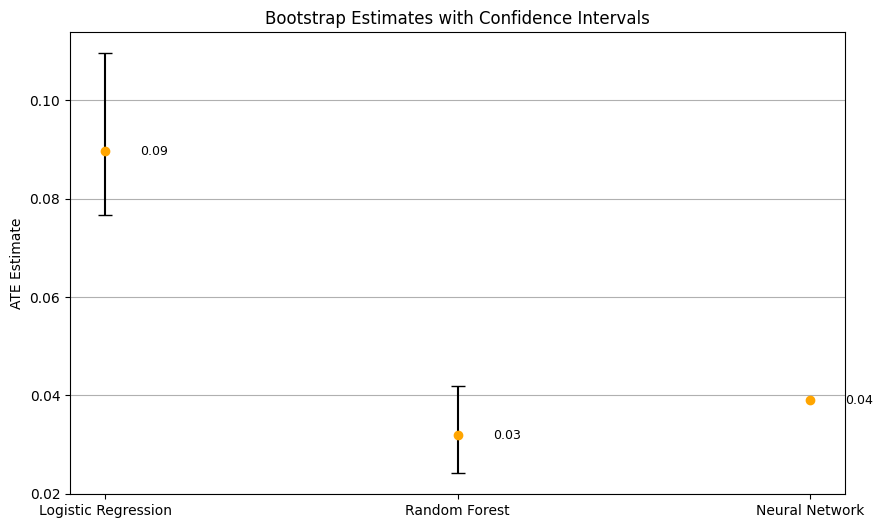

In [ ]:
plot_bootstrap_estimates_boxplot([v[1] for v in results_dict_dr_t_learner.values()], ['Logistic Regression', 'Random Forest', 'Neural Network'], box_color = "orange")

In [ ]:
save_bootstrap_reses_to_json(results_dict_dr_t_learner, "bootstrap_reses_dr_t_learner.json")

### S-Learner

In [ ]:
def bootstrap_confidence_interval_dr_s_learner(s_learner_model, X_train, y_train, X_val, y_val, propensity_model, sample_size=10000, sample_num=20):
    np.random.seed(42)
    bootstrap_sample_size = sample_size
    bootstrap_sample_num = sample_num
    alpha = 0.05
    test_data  = pd.concat([X_val, y_val], axis=1)
    s_learner_model_train_data = deepcopy(X_train) # notice that T is not included in learning
    ate_estimates = []
    # Bootstrap sampling and model fitting
    for i in range(bootstrap_sample_num):
        s_learner_model = s_learner_model.get_model_no_train()
        old_params = propensity_model.get_params()
        IPW_model = LogisticRegression(**old_params) # best previously found propensity model
        # Generate bootstrap indices
        bootstrap_indices = np.random.choice(s_learner_model_train_data.index,
                                            size=bootstrap_sample_size,
                                            replace=True)
        # Create the bootstrap sample using the indices
        X_train_resampled = s_learner_model_train_data.loc[bootstrap_indices]
        y_train_resampled = y_train.loc[bootstrap_indices]

        # fit outcome model
        s_learner_model.fit(X_train_resampled, y_train_resampled)

        # fit propensity model
        IPW_model.fit(X_train_resampled.drop(columns=['T'], inplace = False), X_train_resampled['T'])
        # get propensity on test
        temp_test_data = deepcopy(test_data)
        temp_test_data['propensity'] = IPW_model.predict_proba(temp_test_data[confounders])[:, 1]
        X_val_1 = X_val.copy()
        X_val_0 = X_val.copy() 

        X_val_1['T'] = 1
        X_val_0['T'] = 0

        temp_test_data['y1_estimate'] = s_learner_model.predict(X_val_1)
        temp_test_data['y0_estimate'] = s_learner_model.predict(X_val_0)
        temp_test_data['dr1_estimate'] = temp_test_data.apply(lambda x: dr_estimator(x, 1), axis=1)
        temp_test_data['dr0_estimate'] = temp_test_data.apply(lambda x: dr_estimator(x, 0), axis=1)
        ate_estimate = np.mean(temp_test_data['dr1_estimate'] - temp_test_data['dr0_estimate'])
        ate_estimates.append(ate_estimate)

    # Convert the list of estimates into a numpy array
    dr_bootstrap_estimates = np.array(ate_estimates)

    # Calculate the lower and upper percentiles to get the CI
    dr_ci = np.percentile(dr_bootstrap_estimates, [100 * alpha / 2, 100 * (1 - alpha / 2)], axis=0)

    # Print the confidence interval (for example, for the first prediction)
    print(f"95% Confidence Interval: Lower = {dr_ci[0]}, Upper = {dr_ci[1]}")

    return dr_ci, ate_estimates

In [191]:
results_dict_dr_s_learner = {
    "logist_reg": bootstrap_confidence_interval_dr_s_learner(best_model_logist_reg.get_model_no_train(), X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model, sample_size=X_train_trimmed.shape[0], sample_num=20),
    "rand_forest": bootstrap_confidence_interval_dr_s_learner(best_model_rand_forest.get_model_no_train(), X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model, sample_size=X_train_trimmed.shape[0], sample_num=20),
    "nn": bootstrap_confidence_interval_dr_s_learner(best_model_nn.get_model_no_train(), X_train_trimmed, y_train_trimmed, X_val_trimmed, y_val_trimmed, chosen_propensity_model, sample_size=10000, sample_num=20),
}

c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Lenovo\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting pena

95% Confidence Interval: Lower = -0.04439775836290269, Upper = -0.03933651250746218
95% Confidence Interval: Lower = -0.03628872553049584, Upper = -0.03197990169026557


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23472\2822716881.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


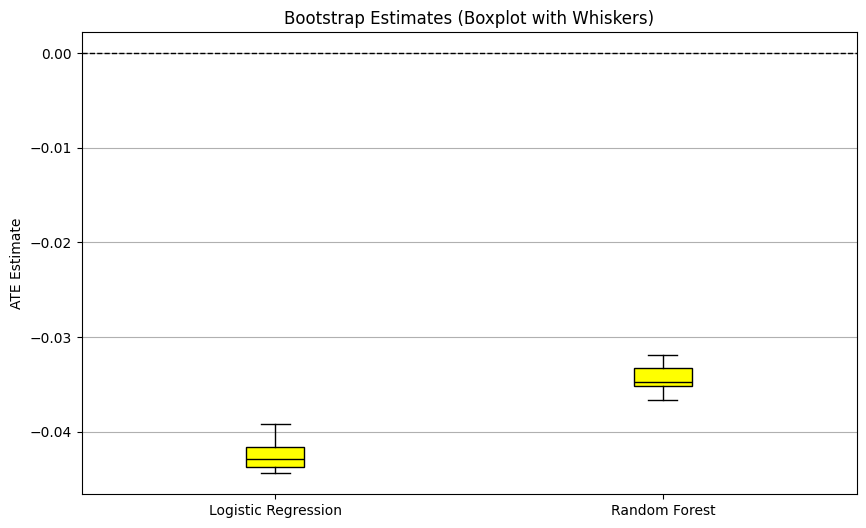

In [ ]:
plot_bootstrap_estimates_boxplot([v[1] for v in results_dict_dr_s_learner.values()], ['Logistic Regression', 'Random Forest', 'Neural Network'], box_color="yellow")

In [ ]:
save_bootstrap_reses_to_json(results_dict_dr_s_learner, "bootstrap_reses_dr_s_learner.json")